# TITLE HERE XXX

## To do
- Clarify terminology on UK vs England

## Introduction
The land-sharing vs. land-sparing debate has received a lot of attention in recent years CITE. DEFINE.
https://www.cam.ac.uk/research/news/relocating-farmland-could-turn-back-clock-twenty-years-on-carbon-emissions


Complex tradeoffs exist e.g. between food security, economics for agricultural businesses and communities, agricultural sustainability and nature impacts and dependencies.

Here weigh in on the LS/LS debate: "having volunteered with several agricutlural business focussing on low-input, extensive practices, I've seen first-hand the effects of .... " but management decisions taken at an individual property level may not take account of larger scale patterns (for instance a farm in a prime-production region opting for extensive management, locally benefiting biodiversity but forfeiting productivity, resulting in supply leakage and land-conversion elsewhere which may offset local benefits); a policy that is coherent at a higher spatial-scale is needed to ensure a globally beneficial solution satisfing food production requirements, biodiversity goals and social economic factors.


Data-centric tools can be a key tool to aid in that decision-making processes. In particular, increasing availability of remote sensing data and biodiversity survey data. We can answer questions like where should we maximise food production, where should we prioritise rewilding efforts or soil health restoration - should we implement blanket policies (i.e. every farm should move towards regenerative methods), or opt for hetergenous strategies (fully rewild some areas, farm extensively in others and intensively in the rest). How do these decisions effect conservation and restoration efforts at a national and international scale, what are the social and economic implications for farming communities and society as a whole.


Here I investigate one facet of this complex question, making use of remote sensing, agricultural data and biodiversity surveys on the UK to look at the relationship between agricultural management, biodiversity and land-use patterns.

The UK is one of the most biodiversity depleted countries in the world CITE, with a significant portion of its surface dedicated to agriculture CITE, so this is a pertinent question to investigate. Furthermore there is significant appetite in the UK for changing agricultural practices CITE, and whilst the government has introduced policy in line with that trend CITE, key questions remain around the LS/LS debate.



__what does this notebook show - what are the results and conclusions? e.g. I found a correlation between x and y, and identified priority areas for changing ag strategies__

__Objectives__ </br>
a. 
Can the approach presented in [1], which links remote sensing parameters with biodiversity survey data, be applied to UK Pollinator Monitoring Scheme (PMS) data? To this end, I replicate the methodolgy in [1] to generate remote sensing crop productivity parameters, compute similar biodiversity metrics on PMS data and test the correlation between the resulting datasets.

b.
Present an example of a large-spatial scale product that may be used to inform ag policy with biodiversity in mind (IYR). Look at IYR values on PMS data localities (potentially for this one look a PMS citizen science data instead of trap data). Identify areas for de-intensification of farming.:

Looking at the distribution of PMS sampling locations with reference to honeybee-specific pesticide input to crop yield ratios (IYR) [2] can any potential priority areas for de-intensification be identified.


In [192]:
# Vector processing
import geopandas as gpd
import shapely
import osgb
import pyproj

# Raster processing
import rasterio
import rasterio.features
from skimage import measure


# Calcs and modelling
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
from matplotlib import pyplot as plt
import contextily as cx

%matplotlib widget
mpl.rcParams['axes.formatter.limits'] = (0,0)
FIGSIZE = (10, 7)

# Practical
import os
import warnings
from pystac_client import Client
import boto3

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

WORKING_CRS = 'EPSG:3035'

## Methods

### Study area
I'm carrying out this analysis on the UK. The UK is one of the most nature depleted countries in the world [3], reflected in very low values of measures of ecosystem intactness compared with other countries.

For instance, the UK's mean Biodiversity Intactness Index (BII) [5] ranks amongst the lowest six countries globally for the period 1970 - 2014, corresponding to the lowest 3% of countries for which the index is computed. The BII was developed by the Natural History Museum, London (NHM), and estimates the percentage of original ecological communities remaining in a given area in light of human disturbance, by combining two models: one representing the influence of human activity on species abundance, and a second measuring compositional similarity (i.e. between an ecosystem at a given location and an undisturbed equivalent).

A more recently presented measure, the Ecosystem Integrity Index, developed by UNEP-WCMC [4] measures departure from natural ecosystem baselines as the minimum value of three components (ecosystem structure, composition and function). The maps presented in that preprint clearly show very low EII values for the UK and particularly for England.




In [131]:
# Read in BII
bii = pd.read_json('../../../data/NHM_BII/resource.json').replace('NA', pd.NA).dropna(subset=['value', 'area_code'], how='any').astype({'value': float})
bii = bii[(bii['variable'] == 'bii') & (bii['scenario'] =='historical')]

# Area code map
code_map_bii = pd.read_json('../../../data/NHM_BII/code_maps.json')[['value', 'label']]
code_map_bii['value'] = code_map_bii['value'].str.replace('.','-')
area_codes_bii = dict(code_map_bii.values)
bii['area'] = bii['area_code'].map(lambda x: area_codes_bii.get(x, pd.NA))
bii = bii[bii['area_code'].str.contains('[A-Za-z]')].dropna(subset=['area']) # countries only

# Rank
bii['year_rank_pct'] = 100.0*bii.groupby(['year'])['value'].rank('dense', pct=True)
bii['year_rank'] = bii.groupby(['year'])['value'].rank('dense')

# Result
print('Maximum BII ranking of the UK compared with other countries across period 1970 - 2014 (absolute rank and as rank percentile of all country measurements per year):')
bii[bii['area_code'] == '001-150-154-GBR'].groupby('area')[['year_rank', 'year_rank_pct']].max()

Maximum BII ranking of the UK compared with other countries across period 1970 - 2014 (absolute rank and as rank percentile of all country measurements per year):


,year_rank,year_rank_pct
area,,
United Kingdom of Great Britain and Northern Ireland,6.0,3.174603


Land use in England is dominated by agriculture. According to the 2023 data from the "Structure of the agricultural industry in England and the UK at June" report compiled by DEFRA [6], 68% of England's land is dedicated to agriculture (down from 74% in 1983), of which 39% is used to grow cereal crops (excluding maize) and 16% is temporary or permanent grassland.

At the same time, land use intensity has increased significantly since the 1960s with productivity gains driven by mechanisation and widespread availability of chemical inputs. For instance global inorganic nitrogen use in the agricultural industry have increased by an order of magnitude in the 60 years since FAO records began in 1961.

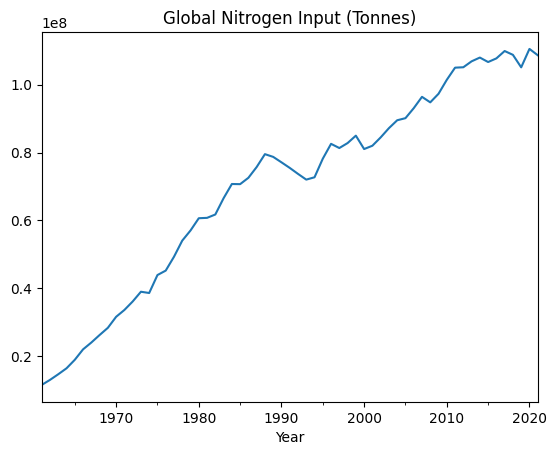

In [10]:
fert_series = pd.read_csv('../../../data/Agric_data/Global_fertiliser_input/FAOSTAT_data_en_2-20-2024.csv', parse_dates=['Year'])
fert_series.set_index('Year')[['Value']].plot(legend=False)
plt.title('Global Nitrogen Input (Tonnes)')
plt.show()

Nitrogen input level is considered a key indicator of land-use intensity [7], which in turn is a central driver of global biodiversity decline [1, 7 - 11] READ THESE AND CHECK RELEVANCE.

The ability to assess land-use intensity at scale, and implications for biodiversity, is therefore relevant to the decision-makers attempting to reconcile biodiversity strategies with social and economic constraints associated with the agricultural industry.

### Biodiversity Data

Here I'm using data from the UK Pollinator Monitoring Scheme (PoMS) [12], which provides pan-trap records relating to systematic 1 km square surveys at 95 locations across the UK. The squares are visited four times per year for data collection. The UK PoMS is the only scheme in the world to conduct systematic pollinator survey data on pollinator species abundance at a national scale [13].

In [59]:
sample_data = gpd.read_file("../../../data/Agric_data/Pollinator/data/ukpoms_1kmpantrapdata_2017-2020_samples.csv")
insect_data = gpd.read_file("../../../data/Agric_data/Pollinator/data/ukpoms_1kmpantrapdata_2017-2020_insects.csv")

# X1km_square is the SW corner of the 1KM grid cell - so add 500m to centre the reference
sample_data['X1km_centre'] = sample_data['X1km_square'].str[:4].str.cat(sample_data['X1km_square'].str[4:], sep='5') + '5'
insect_data['X1km_centre'] = insect_data['X1km_square'].str[:4].str.cat(insect_data['X1km_square'].str[4:], sep='5') + '5'

sample_data['geometry'] = sample_data['X1km_centre'].apply(osgb.gridder.parse_grid).apply(osgb.grid_to_ll).apply(lambda x: (x[1], x[0])).apply(shapely.geometry.Point)
insect_data['geometry'] = insect_data['X1km_centre'].apply(osgb.gridder.parse_grid).apply(osgb.grid_to_ll).apply(lambda x: (x[1], x[0])).apply(shapely.geometry.Point)


# Count records
insect_data['count'] = insect_data['count'].astype(int)
insect_data.groupby('year')['count'].sum()

year
2017    2103
2018    3255
2019    4326
2020    1538
Name: count, dtype: int64

I select one year to proceed with to simplify the analysis - 2019 has the most records so we'll go with that.

In [60]:
insect_data = insect_data[(insect_data['year'] == '2019')]
sample_data = sample_data[(sample_data['year'] == '2019')]


# Convert to an equal-area projection with units metres - so all the study areas have the same area
insect_data.set_crs('EPSG:4326', inplace=True).to_crs(WORKING_CRS, inplace=True)
sample_data.set_crs('EPSG:4326', inplace=True).to_crs(WORKING_CRS, inplace=True)

For the purposes of estimating agricultural intensity in the vicinity of each sampling location, I consider a circle of radius 5 km centred on the sampling location. 

This represents a divergence from the methodology described in [1], where only the fields surveyed were selected for imagery analysis. As the S2 method is described for spring-sown cereals and there can be significant differences in vegetation indexes for different species CITE, and furthermore there is no guarantee that the PoMS survey locations are on spring-sown cereal fields, it is not possible to exactly replicate the methodology here.

Instead I look at the S2 imagery on grassland and cropland (specifically spring-sown cereals) in the vicinitiy of the PoMS sampling location to estimate the local land-use intensity proxy. To this end, I define a circle of radius two kilometres around the PoMS sampling location and calculation S2 indices on these areas.

Note that honey bees regularly travel this distance to forage, and have been witnessed more than 10 km from the hive [14], so defining a study zone around each sampling location in this way is not only practical within the constraints of the methodology here but also likely largely overlaps with areas frequented by the insects observed in the pan-traps.

In [412]:

# For each location download the S2 images and CROME data for the study zone 


def create_zone_dir(dir_name):
    base_path = '../../../data/Agric_data/Locations/'
    to_make = os.path.join(base_path, dir_name)
    if os.path.exists(to_make):
        return to_make
    else:
        os.mkdir(to_make)
        print('Created data dir at ' + to_make)
        return to_make

def read_S3(href, aoi_bbox_geodetic):
    with rasterio.open(href) as src:
        # Note that src crs may be different from the working crs in this notebook or lat/lon so transform to it!
        transform_geodetic_to_s2 = pyproj.Transformer.from_crs("EPSG:4326", src.crs, always_xy=True).transform
        src_bbox = transform_geodetic_to_s2(*aoi_bbox_geodetic)
        window = rasterio.windows.from_bounds(min(src_bbox[0]),
                                              min(src_bbox[1]), 
                                              max(src_bbox[0]), 
                                              max(src_bbox[1]),
                                              transform=src.transform)
        data = src.read(window=window) 
        src_profile = src.profile
        
        src_profile.update({'width': window.width,
                            'height': window.height,
                            'transform': rasterio.windows.transform(window, src.transform)})

    return {'data': data, 'profile': src_profile}

def pass_clouds(thematic_data, max_cloud_perc=None):
    medium_cloud_prob = np.sum(thematic_data == 8)
    high_cloud_prob = np.sum(thematic_data == 9)

    return 100 * ((medium_cloud_prob + high_cloud_prob) / np.size(thematic_data)) < max_cloud_perc

def clean_dir(path):
    files = os.listdir(path)
    if len(files) > 0:
        for file in files:
            print(f'Cleaning (removing) {file}')
            os.remove(os.path.join(path, file))
        
    
    

# Set the study zones and corresponding bbox geoms for data download
sample_data['study_zone'] = sample_data.geometry.buffer(2e3)
sample_data['study_zone_bbox'] = shapely.box(*np.split(sample_data['study_zone'].bounds.values, 4, axis=1)).flatten()

location_geom_lookup = sample_data.drop_duplicates('location_code').set_index('location_code')[['geometry', # point at centre of study zone
                                                                                                     'study_zone', # circular zone around that point to be used for computation
                                                                                                     'study_zone_bbox', # bbox around that circular zone to be used for data download
                                                                                                    ]].to_dict(orient='index')

# Instantiate a stac client to download the images
client = Client.open("https://earth-search.aws.element84.com/v1")

# Instantiate an AWS session to download S2 imagery
aws_session = rasterio.session.AWSSession(boto3.Session(),
                                         requester_pays=True)

# Create a transformer to map projected coords back to geodetic coords
transform_working_to_geodetic = pyproj.Transformer.from_crs(pyproj.CRS(WORKING_CRS), 
                                                            pyproj.CRS('EPSG:4326'), 
                                                            always_xy=True).transform

# Choose which bands to download
band_names = ['red', 'nir', 'visual']

with rasterio.Env(aws_session):
    for location_code in sample_data['location_code'].unique():
        print('Starting processing for location number ' + str(location_code))
        dir_name = 'location_' + str(location_code )
        data_path = create_zone_dir(dir_name)
    
        aoi_bbox = location_geom_lookup[location_code]['study_zone_bbox'] # in projected coords
        aoi_bbox_geodetic = transform_working_to_geodetic(*aoi_bbox.exterior.xy)
        aoi_geodetic_shapely = shapely.geometry.Polygon(np.stack(aoi_bbox_geodetic, axis=1))

        # For this AOI looks the crop map (CROME) data and identify relevant masks
        # crome_grassland = 
        # crome_spring_cereals = 
        # crome_grassland_or_spring_cereal = 
    
        # Search catalogue
        search = client.search(max_items=100,
                                collections=['sentinel-2-l2a'],
                                # query=['eo:cloud_cover<50'],
                                bbox=[min(aoi_bbox_geodetic[0]),
                                      min(aoi_bbox_geodetic[1]), 
                                      max(aoi_bbox_geodetic[0]), 
                                      max(aoi_bbox_geodetic[1])],
                                datetime='2019-01-01/2020-01-01'
                            )
    
        # For each result get the following bands
        for item in search.items():
            # First check this S2 capture fully covers the AOI
            assert shapely.geometry.box(*item.bbox).contains(aoi_geodetic_shapely)
            
            # Store date reference
            date_ref = item.datetime.strftime('%Y_%m_%d')
            print(f'\tProcessing {date_ref}')

            # Start with a cloud check
            s2_thematic = read_S3(item.assets['scl'].href, aoi_bbox_geodetic)
            max_cloud_perc = 10
            if not pass_clouds(s2_thematic['data'], max_cloud_perc=max_cloud_perc):
                print(f'Too cloudy, skipping (more than {max_cloud_perc}% of image medium or high cloud probability).')
                continue

            # Read data from S3 - already calculated scl so just add that to the dictionary instead of redownloading
            band_data = {band_name: read_S3(item.assets[band_name].href, aoi_bbox_geodetic) for band_name in band_names}
            band_data['scl'] = s2_thematic

            # Create masks on which to calculate evi2
            s2_valid_mask = s2_thematic['data'] == 4
            
            # Calculate evi2
            evi2 = 2.5 * (band_data['nir']['data'] - band_data['red']['data']) / (band_data['nir']['data'] + 2.4*band_data['red']['data'] + 1)
        
            # TO DO - further filter evi2 based on CROME designation and s2_valid_mask and write these arrays instead

            evi2_profile = {**band_data['nir']['profile'].copy(), **{'nodata':np.nan, 'dtype': 'float32'}}
            band_data['evi2'] = {'data': evi2, 'profile': evi2_profile}
            

            # Write band data 
            base_write_path = os.path.join(data_path, date_ref)
            if not os.path.exists(base_write_path):
                os.mkdir(base_write_path)
            else:
                clean_dir(base_write_path)
                
            for band_name, data_profile in band_data.items():
                full_write_path = os.path.join(base_write_path, band_name + '.tif')
                
                # Source bounds:
                transformer = rasterio.transform.AffineTransformer(data_profile['profile']['transform']) 
                left, top = transformer.xy(0,0, offset='ul')
                right, bottom = transformer.xy(data_profile['profile']['height'], data_profile['profile']['width'], offset='ul')
                
                # Get default transform
                transform, width, height = rasterio.warp.calculate_default_transform(data_profile['profile']['crs'], 
                                                                        WORKING_CRS, 
                                                                        data_profile['profile']['width'], 
                                                                        data_profile['profile']['height'], 
                                                                        left=left,
                                                                        bottom=bottom,
                                                                        right=right,
                                                                        top=top)
                _profile = data_profile['profile'].copy()
                _profile.update({'crs': WORKING_CRS,
                                'transform': transform,
                                'width': width,
                                'height': height})
                
                print(f'Writing to {full_write_path}')
                with rasterio.open(full_write_path, 'w', **_profile) as dst:
                    for i in range(1, _profile['count'] + 1):
                        rasterio.warp.reproject(source=data_profile['data'],
                                                destination=rasterio.band(dst, i),
                                                src_transform=data_profile['profile']['transform'],
                                                src_crs=data_profile['profile']['crs'],
                                                dst_transform=transform,
                                                dst_crs=WORKING_CRS,
                                                resampling=rasterio.warp.Resampling.nearest)
                    
                
        
            
            
            
            break
        break

# https://www.matecdev.com/posts/landsat-sentinel-aws-s3-python.html
# https://pystac-client.readthedocs.io/en/stable/api.html#pystac_client.Client.search



Starting processing for location number 25
	Processing 2019_12_30
Cleaning (removing) red.tif
Writing to ../../../data/Agric_data/Locations/location_25/2019_12_30/red.tif
Writing to ../../../data/Agric_data/Locations/location_25/2019_12_30/nir.tif
Writing to ../../../data/Agric_data/Locations/location_25/2019_12_30/visual.tif
Writing to ../../../data/Agric_data/Locations/location_25/2019_12_30/scl.tif
Writing to ../../../data/Agric_data/Locations/location_25/2019_12_30/evi2.tif


In [413]:
with rasterio.open(full_write_path) as file:
    print(file.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 540, 'height': 540, 'count': 1, 'crs': CRS.from_epsg(3035), 'transform': Affine(9.999781860742237, 0.0, 3634307.258307037,
       0.0, -9.999781860742237, 3291295.251578977), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


<Axes: >

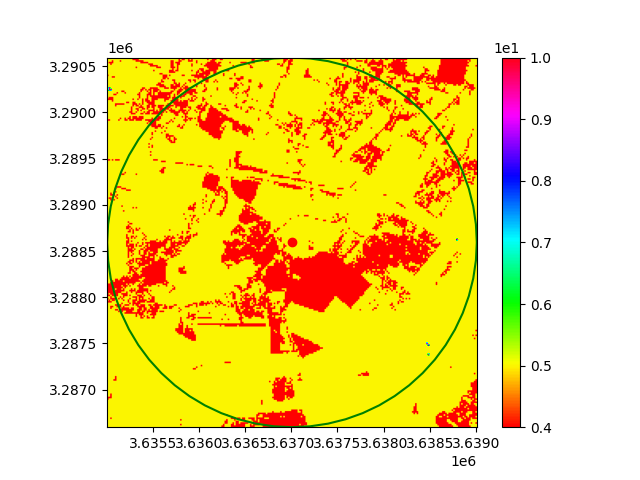

In [317]:
# Plot example
fig, ax = plt.subplots()
im = ax.imshow(thematic_data, cmap='hsv', extent = [aoi_bbox.bounds[0], aoi_bbox.bounds[2], aoi_bbox.bounds[1], aoi_bbox.bounds[3]])
plt.colorbar(im)
gpd.GeoSeries([location_geom_lookup[location_code]['geometry']], crs=WORKING_CRS).plot(ax=ax, color='red')
gpd.GeoSeries([location_geom_lookup[location_code]['study_zone'].exterior], crs=WORKING_CRS).plot(ax=ax, color='green')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

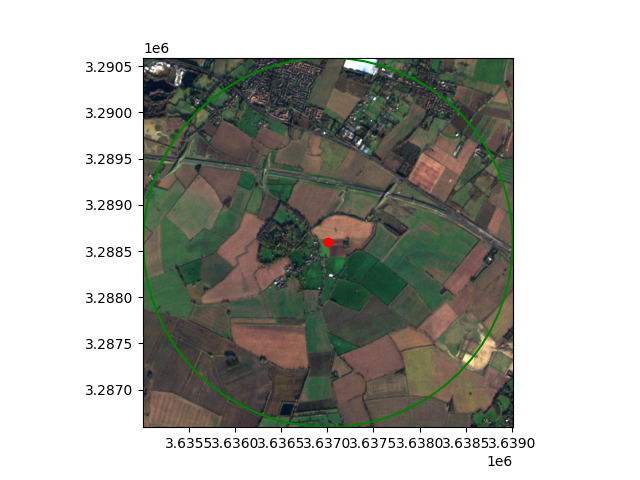

In [318]:
# Plot example
fig, ax = plt.subplots()
ax.imshow(np.stack(band_data[1:4], axis=2)*5, extent = [aoi_bbox.bounds[0], aoi_bbox.bounds[2], aoi_bbox.bounds[1], aoi_bbox.bounds[3]])
gpd.GeoSeries([location_geom_lookup[location_code]['geometry']], crs=WORKING_CRS).plot(ax=ax, color='red')
gpd.GeoSeries([location_geom_lookup[location_code]['study_zone'].exterior], crs=WORKING_CRS).plot(ax=ax, color='green')


__Remote Sensing and Biodiversity Survey Data__ </br>
Following the methodology presented by Abdi et al. [1], I calculate productivity parameters based on Sentinel-2 imagery.




Replicate the methodology in [1] to generate remote sensing crop productivity parameters, compute similar biodiversity metrics on PMS data and test the correlation between the resulting datasets.

1. Get sampling locations
2. Define bboxes on each (look at foraging distances)
3. Looking at PMS data, select one year to focus on, based on sample prevalence in PMS data </br>
4. Download CROME and S2 data on the bboxes for that year
5. Calculate S2 indices on each bbox -> timeseries </br>
Some sampling locations won't have any cereals grown nearby - ie permanent pasture - so for those locations let's use the same index, but track the following: </br>
> - proportion of the nearby area on which the index is calculated - EDVI based on just spring sown cereals
> - EDVI based on just pasture (grassland)
> - EDVI based on both cereals and grasses
> - Area proportions of those groups in the bbox / radius

6. Apply timeseries analysis in [1] to derive S2 annual features (AMPL, MAX)
7. Calculate PMS indices at locations
8. Calculate correlations between S2 metrics and PMS indices, including probabilities (at this stage take inspiration from [1] for the testing)


Check defintiion of "spring cereals" - spring sown barley wheat and oat (cereals)??
Look to see if CROME has an api
What about confounders (i.e. climatic variables affecting species richness and agricultural productivity)


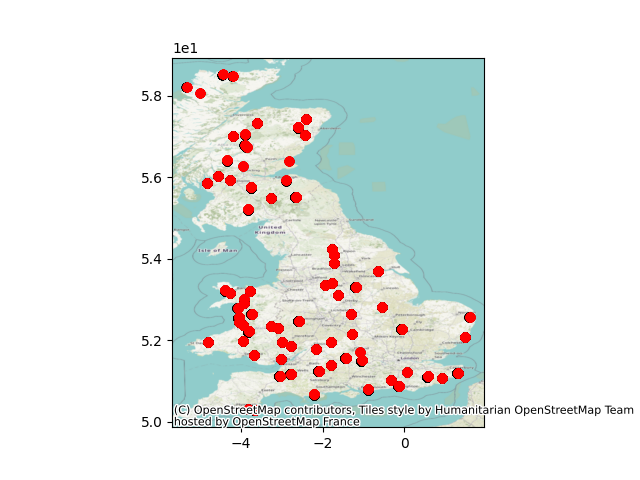

In [44]:
ax = gpd.GeoSeries(insect_data['X1km_square'].apply(osgb.gridder.parse_grid).apply(osgb.grid_to_ll).apply(lambda x: (x[1], x[0])).apply(shapely.geometry.Point), crs='EPSG:4326').plot(color='black')
gpd.GeoSeries(insect_data['X1km_centre'].apply(osgb.gridder.parse_grid).apply(osgb.grid_to_ll).apply(lambda x: (x[1], x[0])).apply(shapely.geometry.Point), crs='EPSG:4326').plot(color='red', ax=ax)
cx.add_basemap(ax, crs='EPSG:4326')

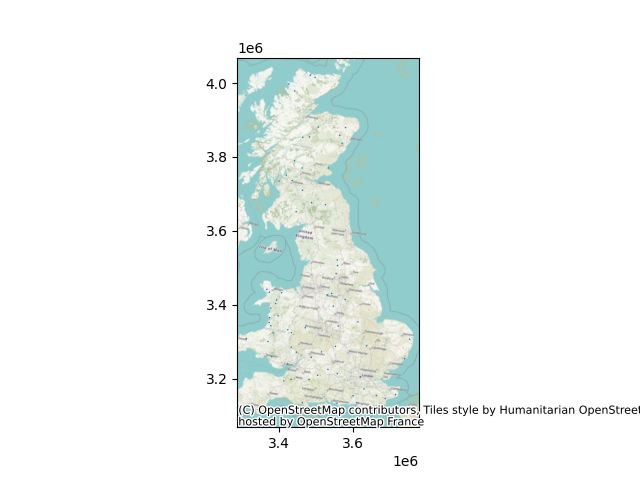

In [53]:
ax = insect_data.drop_duplicates(subset=['geometry']).plot()
cx.add_basemap(ax, crs=insect_data.crs)

In [76]:
with rasterio.open("../../../data/Agric_data/IYR/data/input_to_yield_ratio_honeybees.tiff") as file:
    ref_profile = file.profile
    bee_iyr = file.read(1)
    extent = [getattr(file.bounds, i) for i in ['left', 'right', 'bottom', 'top']] #lrbt

In [79]:
bee_iyr = np.where(bee_iyr == ref_profile['nodata'], np.nan, bee_iyr)

In [80]:
ref_profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 524, 'height': 652, 'count': 1, 'crs': CRS.from_epsg(27700), 'transform': Affine(1000.0, 0.0, 132000.0,
       0.0, -1000.0, 658000.0), 'blockysize': 3, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [85]:
%matplotlib widget

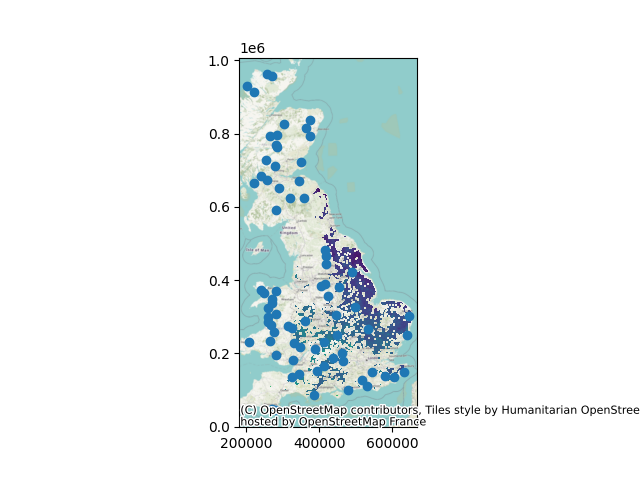

In [86]:
fig, ax = plt.subplots()

insect_data.to_crs(ref_profile['crs']).drop_duplicates(subset=['geometry']).plot(ax=ax)
cx.add_basemap(ax, crs=ref_profile['crs'])
ax.imshow(bee_iyr, interpolation=None, extent = extent)

In [91]:
insect_data.to_crs(ref_profile['crs'], inplace=True)

0       POLYGON ((480001.195 99998.934, 479991.565 998...
12      POLYGON ((348999.747 218000.616, 348990.117 21...
15      POLYGON ((262999.290 285001.769, 262989.659 28...
36      POLYGON ((332999.574 229000.751, 332989.944 22...
64      POLYGON ((346999.600 142999.335, 346989.970 14...
                              ...                        
2179    POLYGON ((288000.159 763998.614, 287990.529 76...
4134    POLYGON ((205999.390 928997.627, 205989.760 92...
4313    POLYGON ((285000.143 768998.623, 284990.512 76...
7791    POLYGON ((286000.076 796998.485, 285990.446 79...
7864    POLYGON ((350999.719 722999.027, 350990.089 72...
Length: 76, dtype: geometry

In [107]:
ref_profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 524, 'height': 652, 'count': 1, 'crs': CRS.from_epsg(27700), 'transform': Affine(1000.0, 0.0, 132000.0,
       0.0, -1000.0, 658000.0), 'blockysize': 3, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [115]:
insect_data_mask = rasterio.features.rasterize(
    insect_data.drop_duplicates(subset=['geometry']).geometry.buffer(2e3),  # in metres
    out_shape = (ref_profile['height'], ref_profile['width']),
    transform = ref_profile['transform'],
).astype(bool)

NameError: name 'insect_data_mask' is not defined

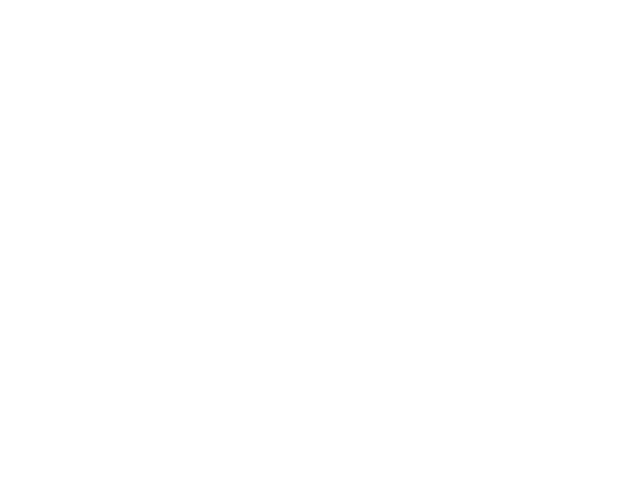

In [230]:
plt.figure()
plt.imshow(insect_data_mask & ~np.isnan(bee_iyr))

In [121]:
len(measure.find_contours(insect_data_mask & ~np.isnan(bee_iyr)))

36

(array([11., 14., 26., 27., 64., 33., 25., 29., 26., 10.]),
 array([0.84367919, 0.87839961, 0.91311997, 0.94784039, 0.98256075,
        1.01728117, 1.0520016 , 1.08672202, 1.12144232, 1.15616274,
        1.19088316]),
 <BarContainer object of 10 artists>)

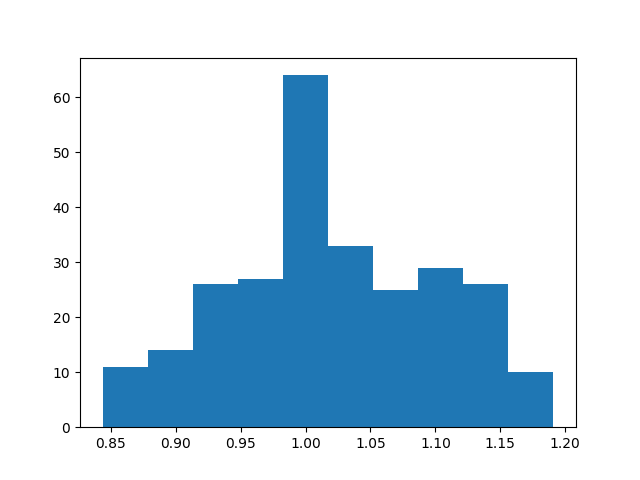

In [125]:
bee_iyr

In [128]:
insect_data[insect_data['year'] == '2018'].groupby('location_code')['taxon_source'].nunique()

location_code
1       4
10     10
100    15
106    20
108    17
       ..
89      4
9      19
91     14
94     28
96     31
Name: taxon_source, Length: 65, dtype: int64

In [143]:
test = gpd.read_file('../../../data/Agric_data/Cropmap/Test/data/Crop_Map_of_England_2019_Oxfordshire.json', engine='pyogrio')

In [145]:
test = test[:100]

In [158]:
test

,OBJECTID,cromeid,lucode,refdate,Shape_Length,Shape_Area,geometry
0,1,RPA433186189544,PG01,20191017,239.998558,4156.872,"POLYGON ((433226.313 189544.016, 433206.313 18..."
1,2,RPA440206186738,AC67,20191017,239.998558,4156.872,"POLYGON ((440246.313 186738.094, 440226.313 18..."
2,3,RPA444466243030,AC01,20191017,239.998558,4156.872,"POLYGON ((444446.313 242995.109, 444486.313 24..."
3,4,RPA425566210225,LG08,20191017,239.998558,4156.872,"POLYGON ((425606.313 210224.703, 425586.313 21..."
4,5,RPA436246229485,AC01,20191017,239.998558,4156.872,"POLYGON ((436266.313 229450.469, 436286.313 22..."
...,...,...,...,...,...,...,...
95,96,RPA450466208319,NA01,20191017,239.998558,4156.872,"POLYGON ((450486.313 208284.813, 450506.313 20..."
96,97,RPA441106230698,AC63,20191017,239.998905,4156.884,"POLYGON ((441126.313 230662.906, 441146.313 23..."
97,98,RPA450406197893,TC01,20191017,239.998558,4156.872,"POLYGON ((450426.313 197857.859, 450446.313 19..."
98,99,RPA440386210952,LG07,20191017,239.998905,4156.884,"POLYGON ((440406.313 210917.516, 440426.313 21..."



__IYR vs PMS__ </br>
Look at IYR values on PMS data localities (potentially for this one look a PMS citizen science data instead of trap data). Identify areas for de-intensification of farming.:

Looking at the distribution of PMS indices with reference to honeybee-specific pesticide input to crop yield ratios (IYR) [2] can any potential priority areas for de-intensification be identified. Any particular risk zones?

## References

1. Abdi AM, Carrié R, Sidemo-Holm W, Cai Z, Boke-Olén N, Smith HG, Eklundh L, Ekroos J, Biodiversity Decline With Increasing Crop Productivity in Agricultural Fields Revealed by Satellite Remote Sensing. Ecological Indicators. 2021; 130():108098. https://doi.org/10.1016/j.ecolind.2021.108098. 
2. Bullock JM, Jarvis SG, Fincham WNW, Risser H, Schultz C, Spurgeon DJ, et al.. Mapping the Ratio of Agricultural Inputs to Yields Reveals Areas With Potentially Less Sustainable Farming. Science of The Total Environment. 2024; 909(): 168491. https://doi.org/10.1016/j.scitotenv.2023.168491.
3. https://stateofnature.org.uk/wp-content/uploads/2023/09/TP25999-State-of-Nature-main-report_2023_FULL-DOC-v12.pdf [Accessed 20/02/2024]
4. https://www.biorxiv.org/content/10.1101/2022.08.21.504707v2
5. Helen Phillips; Adriana De Palma; Ricardo E Gonzalez; Sara Contu et al. (2021). The Biodiversity Intactness Index - country, region and global-level summaries for the year 1970 to 2050 under various scenarios [Data set]. Natural History Museum. https://doi.org/10.5519/he1eqmg1
6. Structure of the agricultural industry in England and the UK at June
7. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2664376/
8. Agricultural intensification and the collapse of Europe's farmland bird populations.
9. Linking agricultural practice to insect and bird populations: a historical study over three decades.
10. Patterns and causes of species endangerment in Canada
11. Farming and the fate of wild nature
12. UK PoMS data download
13. https://uk-scape.ceh.ac.uk/our-science/projects/PoMS [Accessed 20/02/2024]
14. https://www.jstor.org/stable/1541
